In [1]:
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import pandas as pd
import numpy as np
from keras.optimizers import Adam, RMSprop
from keras.models import load_model
import sys
sys.path.append(r'C:\Users\HW\Desktop\Deep Learning\01Assignment\a3\src')
from data_preparation import StockIndexDataset
from rnn_models import *
from utils import plot_seqs, create_labels

In [2]:
# Set constant variables and hyper-parameters for the model training

INPUT_PATH = r"C:\Users\HW\Desktop\Deep Learning\01Assignment\a3\src\data"
OUTPUT_PATH = r'C:\Users\HW\Desktop\Deep Learning\01Assignment\a3\scr\models' 
os.makedirs(OUTPUT_PATH, exist_ok=True)
# Load datasets
datasets_path = [os.path.join(INPUT_PATH, file) for file in sorted(os.listdir(INPUT_PATH))]
for p in datasets_path:
    print(p)

RNN_params = {"batch_size": 32,
              "epochs": 50,
              "lr": 1e-4,
              "time_steps": 30,
              "forecast_steps": 1,
              "window": 30,
              "RNN_size": 128,
              "FC_size": 32,
              "optim": Adam,
              "dropout": 0.5,
              "earlystop": {"patience": 20, 
                            "min_delta": 0.00001},
              "reduce_lr": {"factor": 0.1,
                            "patience": 10,
                            "min_delta": 0.0001}
              }

GRU_params = {"batch_size": 32,
              "epochs": 50,
              "lr": 1e-4,
              "time_steps": 30,
              "forecast_steps": 1,
              "window": 30,
              "RNN_size": 128,
              "FC_size": 32,
              "optim": Adam,
              "dropout": 0.5,
              "earlystop": {"patience": 20, 
                            "min_delta": 0.00001},
              "reduce_lr": {"factor": 0.1,
                            "patience": 10,
                            "min_delta": 0.0001}
              }

LSTM_params = {"batch_size": 32,
               "epochs": 50,
               "lr": 1e-4,
               "time_steps": 30,
               "forecast_steps": 1,
               "window": 30,
               "RNN_size": 128,
               "FC_size": 32,
               "optim": Adam,
               "dropout": 0.5,
               "earlystop": {"patience": 20, 
                             "min_delta": 0.00001},
               "reduce_lr": {"factor": 0.1,
                             "patience": 10,
                             "min_delta": 0.0001}
               }

def display_learningcurve(modelhist):
    df = pd.DataFrame(modelhist.history)

    # Display the first few rows
    print("DataFrame preview:")
    print(df.head())

    # Plot Loss
    plt.figure(figsize=(10, 5))

    plt.subplot(1, 2, 1)
    plt.plot(df.index + 1, df['loss'], label='Training Loss')
    plt.plot(df.index + 1, df['val_loss'], label='Validation Loss')
    plt.title('Loss vs. Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(df.index + 1, df['mda'], label='Training MDA')
    plt.plot(df.index + 1, df['val_mda'], label='Validation MDA')
    plt.title('Mean Directional Accuracy vs. Epochs')
    plt.xlabel('')
    plt.ylabel('Mean Directional Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

def trainRNN(datasets_path, params):
    data = StockIndexDataset(datasets_path, time_steps=params['time_steps'],
                            forecast_steps=params['forecast_steps'],
                            batch_size=params['batch_size'], val_ratio=.1, test_ratio=.1)
    data.info()
    
    input = (data.batch_size, data.time_steps, data.X_train.shape[2])
    model = build_SimpleRNN(input, params)
    filepath = os.path.join(OUTPUT_PATH, "RNN_bestweights.keras")
    callbacks = training_callbacks(['reduce_lr', 'mcp'], params,filepath) 
    hist = model.fit(data.X_train, data.y_train, 
                         epochs=params["epochs"], batch_size=data.batch_size,
                         shuffle=False, validation_data=(data.X_val, data.y_val), 
                         verbose=2, callbacks=callbacks)
    display_learningcurve(hist)

    predictions = ModelPredictions(model, 
                                    X = data.X, 
                                    y = data.y, 
                                    raw_y = data.raw_seq[:,1], 
                                    datetime = data.datetime,
                                    window = params['window'],
                                    batch_size = params['batch_size'])

    labels = ['Actual', 'Training', 'Validation', 'Test']
    predictions.plot_predictions(title="SH300IF (RNN model)", labels=labels)

    return predictions

def trainGRU(datasets_path, params):
    data = StockIndexDataset(datasets_path, time_steps=params['time_steps'],
                            forecast_steps=params['forecast_steps'],
                            batch_size=params['batch_size'], val_ratio=.1, test_ratio=.1)

    input = (data.batch_size, data.time_steps, data.X_train.shape[2])
    model = build_GRU(input, params)
    filepath = os.path.join(OUTPUT_PATH,"GRU_bestweights.keras") 
    callbacks = training_callbacks(['reduce_lr', 'mcp'], params,filepath) 
    hist = model.fit(data.X_train, data.y_train, 
                         epochs=params["epochs"], batch_size=data.batch_size,
                         shuffle=False, validation_data=(data.X_val, data.y_val), 
                         verbose=2, callbacks=callbacks)
    display_learningcurve(hist)
    predictions = ModelPredictions(model, 
                                    X = data.X, 
                                    y = data.y, 
                                    raw_y = data.raw_seq[:,1], 
                                    datetime = data.datetime,
                                    window = params['window'],
                                    batch_size = params['batch_size'])

    labels = ['Actual', 'Training', 'Validation', 'Test']
    predictions.plot_predictions(title="SH300IF (GRU model)", labels=labels)
    return predictions

def trainLSTM(datasets_path, params):
    data = StockIndexDataset(datasets_path, time_steps=params['time_steps'],
                            forecast_steps=params['forecast_steps'],
                            batch_size=params['batch_size'], val_ratio=.1, test_ratio=.1)
    data.info()

    input = (data.batch_size, data.time_steps, data.X_train.shape[2])
    model = build_LSTM(input, params)
    filepath = os.path.join(OUTPUT_PATH,"LSTM_bestweights.keras") 
    callbacks = training_callbacks(['reduce_lr', 'mcp'], params,filepath) 
    hist = model.fit(data.X_train, data.y_train, 
                         epochs=params["epochs"], batch_size=data.batch_size,
                         shuffle=False, validation_data=(data.X_val, data.y_val), 
                         verbose=2, callbacks=callbacks)
    display_learningcurve(hist)
    predictions = ModelPredictions(model, 
                                    X = data.X, 
                                    y = data.y, 
                                    raw_y = data.raw_seq[:,1], 
                                    datetime = data.datetime,
                                    window = params['window'],
                                    batch_size = params['batch_size'])

    labels = ['Actual', 'Training', 'Validation', 'Test']
    predictions.plot_predictions(title="SH300IF (LSTM model)", labels=labels)
    return predictions

C:\Users\HW\Desktop\Deep Learning\01Assignment\a3\src\data\2010.4.1-2012.12.31.txt
C:\Users\HW\Desktop\Deep Learning\01Assignment\a3\src\data\2013.1.4-2014.12.31.txt
C:\Users\HW\Desktop\Deep Learning\01Assignment\a3\src\data\2015-2017.txt
C:\Users\HW\Desktop\Deep Learning\01Assignment\a3\src\data\2017-2019.4.29.txt


Window: time step = 12, forecast step = 6, window = 12
Loading dataset... Ready for training.
Stock Index Code: SH300IF
Train Set Length: 26048
Validation Set Length: 2880
Test Set Length: 3200
Epoch 1/50

Epoch 1: val_loss improved from inf to 0.02036, saving model to C:\Users\HW\Desktop\Deep Learning\01Assignment\a3\scr\models\RNN_bestweights.keras
814/814 - 3s - 4ms/step - loss: 0.0823 - mda: 0.5227 - rmse: 0.2298 - val_loss: 0.0204 - val_mda: 0.5982 - val_rmse: 0.1230 - learning_rate: 1.0000e-04
Epoch 2/50

Epoch 2: val_loss improved from 0.02036 to 0.01320, saving model to C:\Users\HW\Desktop\Deep Learning\01Assignment\a3\scr\models\RNN_bestweights.keras
814/814 - 2s - 2ms/step - loss: 0.0242 - mda: 0.5358 - rmse: 0.1428 - val_loss: 0.0132 - val_mda: 0.5964 - val_rmse: 0.1041 - learning_rate: 1.0000e-04
Epoch 3/50

Epoch 3: val_loss improved from 0.01320 to 0.00232, saving model to C:\Users\HW\Desktop\Deep Learning\01Assignment\a3\scr\models\RNN_bestweights.keras
814/814 - 1s - 2m

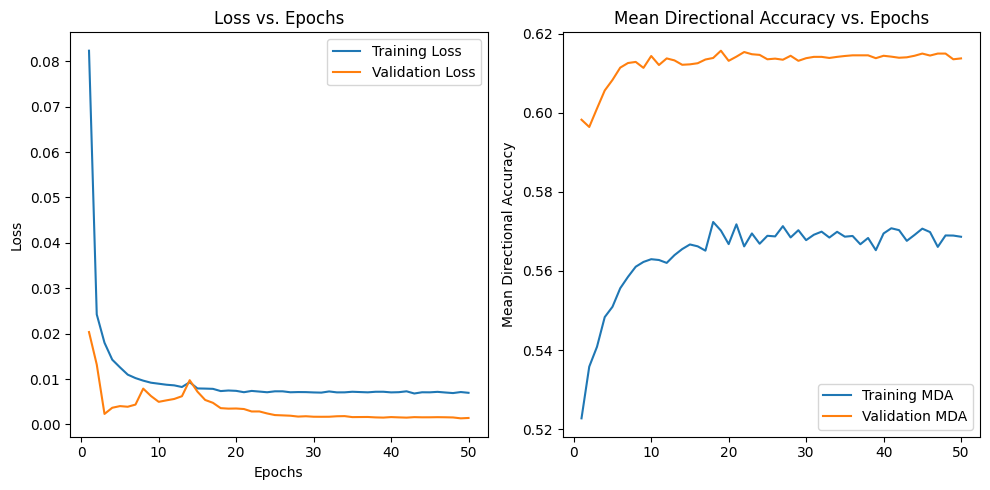

814/814 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


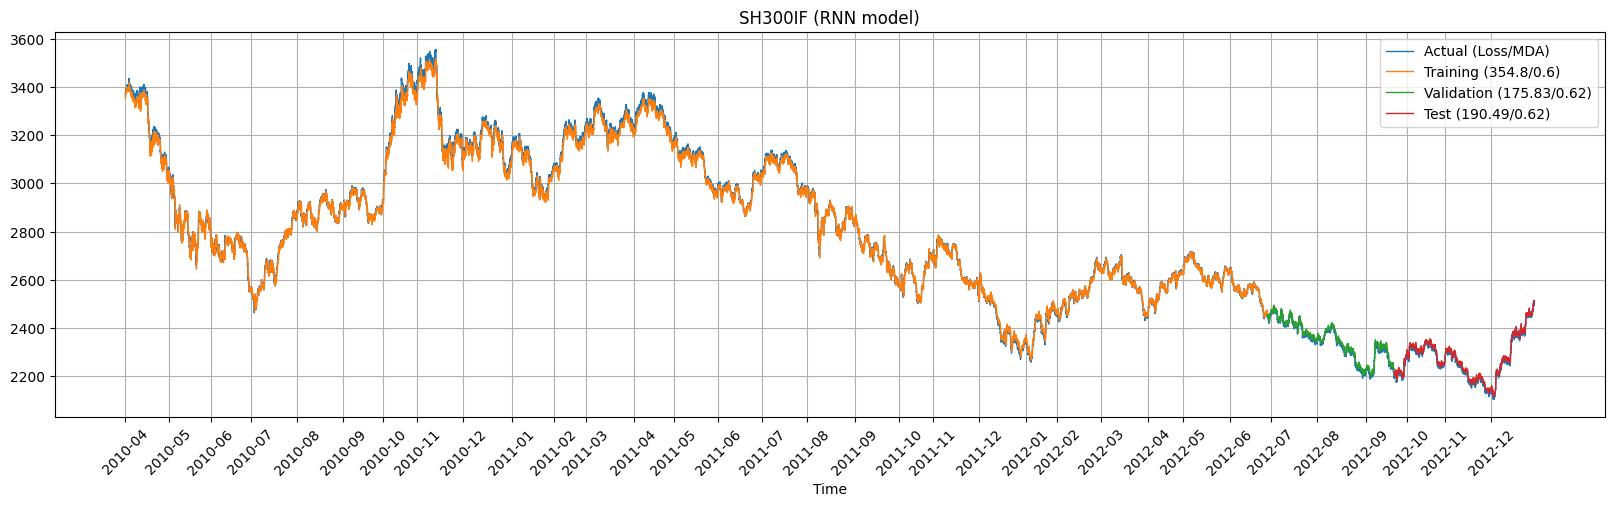

Loading dataset... Ready for training.
Epoch 1/50

Epoch 1: val_loss improved from inf to 0.01339, saving model to C:\Users\HW\Desktop\Deep Learning\01Assignment\a3\scr\models\GRU_bestweights.keras
814/814 - 7s - 8ms/step - loss: 0.0972 - mda: 0.5356 - rmse: 0.2025 - val_loss: 0.0134 - val_mda: 0.6101 - val_rmse: 0.1104 - learning_rate: 1.0000e-04
Epoch 2/50

Epoch 2: val_loss improved from 0.01339 to 0.00730, saving model to C:\Users\HW\Desktop\Deep Learning\01Assignment\a3\scr\models\GRU_bestweights.keras
814/814 - 4s - 5ms/step - loss: 0.0177 - mda: 0.5474 - rmse: 0.1191 - val_loss: 0.0073 - val_mda: 0.6103 - val_rmse: 0.0818 - learning_rate: 1.0000e-04
Epoch 3/50

Epoch 3: val_loss improved from 0.00730 to 0.00574, saving model to C:\Users\HW\Desktop\Deep Learning\01Assignment\a3\scr\models\GRU_bestweights.keras
814/814 - 3s - 4ms/step - loss: 0.0131 - mda: 0.5549 - rmse: 0.1050 - val_loss: 0.0057 - val_mda: 0.6094 - val_rmse: 0.0732 - learning_rate: 1.0000e-04
Epoch 4/50

Epoch 4:

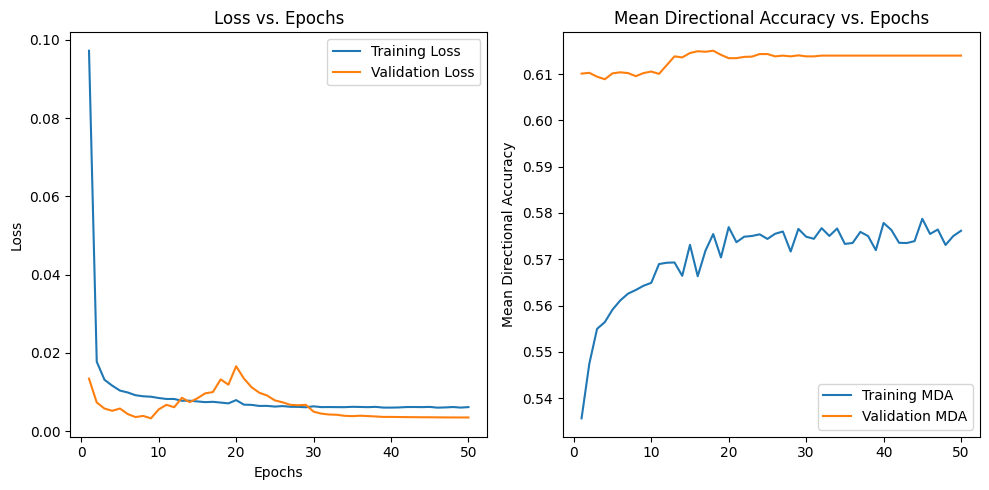

814/814 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


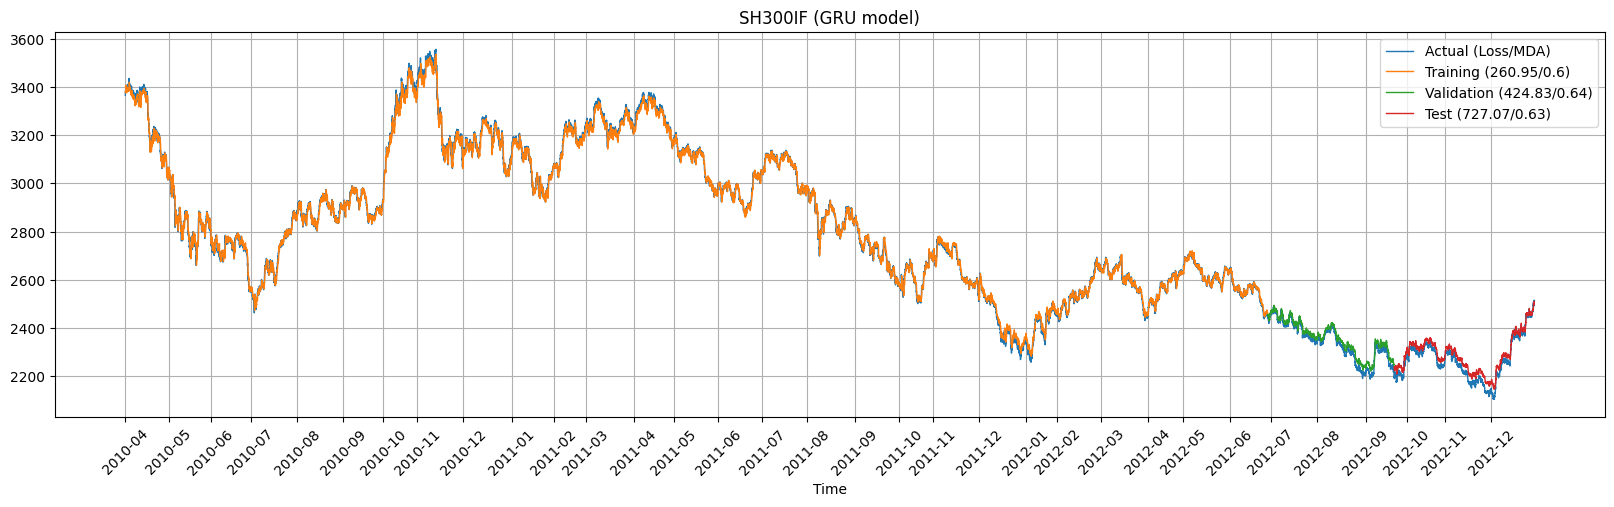

Loading dataset... Ready for training.
Stock Index Code: SH300IF
Train Set Length: 26048
Validation Set Length: 2880
Test Set Length: 3200
Epoch 1/50

Epoch 1: val_loss improved from inf to 0.01648, saving model to C:\Users\HW\Desktop\Deep Learning\01Assignment\a3\scr\models\LSTM_bestweights.keras
814/814 - 7s - 8ms/step - loss: 0.0906 - mda: 0.5236 - rmse: 0.1895 - val_loss: 0.0165 - val_mda: 0.6079 - val_rmse: 0.1128 - learning_rate: 1.0000e-04
Epoch 2/50

Epoch 2: val_loss improved from 0.01648 to 0.01177, saving model to C:\Users\HW\Desktop\Deep Learning\01Assignment\a3\scr\models\LSTM_bestweights.keras
814/814 - 4s - 5ms/step - loss: 0.0191 - mda: 0.5359 - rmse: 0.1185 - val_loss: 0.0118 - val_mda: 0.6118 - val_rmse: 0.0993 - learning_rate: 1.0000e-04
Epoch 3/50

Epoch 3: val_loss improved from 0.01177 to 0.00767, saving model to C:\Users\HW\Desktop\Deep Learning\01Assignment\a3\scr\models\LSTM_bestweights.keras
814/814 - 6s - 7ms/step - loss: 0.0142 - mda: 0.5448 - rmse: 0.1060 -

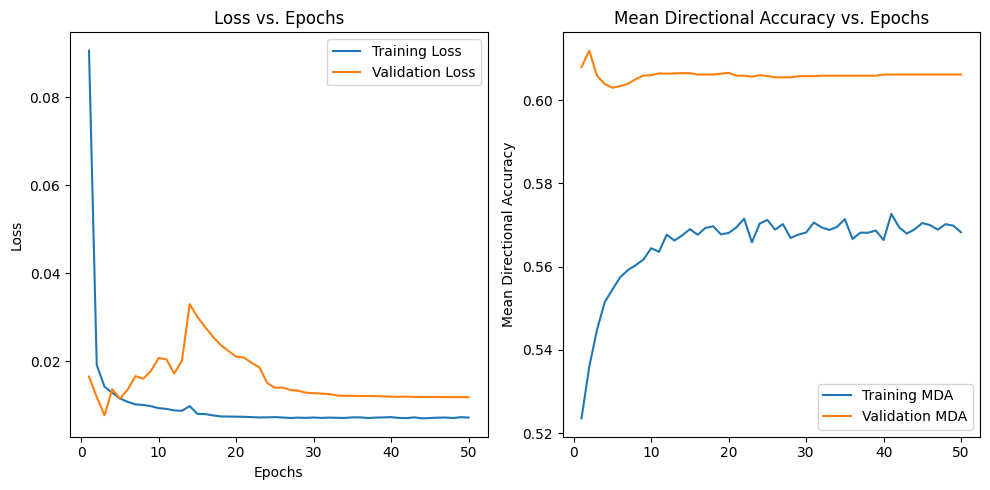

814/814 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


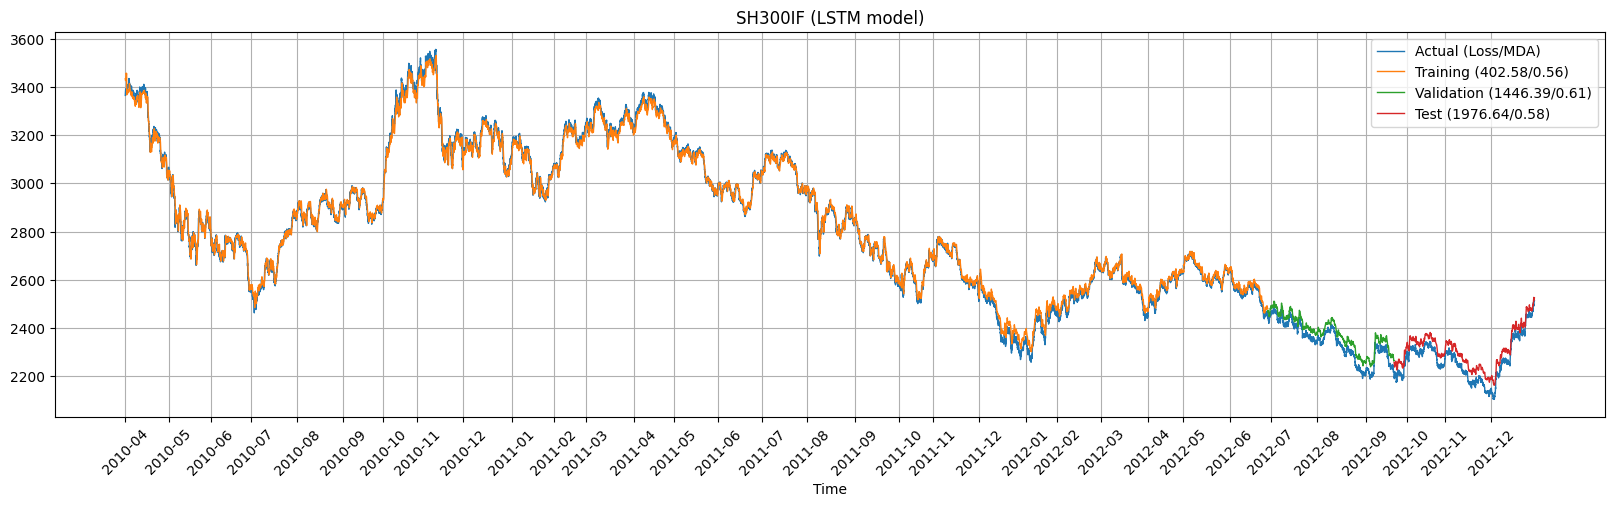

------------------------------------------------------------------------------------------------------

Window: time step = 12, forecast step = 1, window = 12
Loading dataset... Ready for training.
Stock Index Code: SH300IF
Train Set Length: 26048
Validation Set Length: 2880
Test Set Length: 3200
Epoch 1/50

Epoch 1: val_loss improved from inf to 0.01040, saving model to C:\Users\HW\Desktop\Deep Learning\01Assignment\a3\scr\models\RNN_bestweights.keras
814/814 - 3s - 4ms/step - loss: 0.0642 - mda: 0.5360 - rmse: 0.2084 - val_loss: 0.0104 - val_mda: 0.6264 - val_rmse: 0.0833 - learning_rate: 1.0000e-04
Epoch 2/50

Epoch 2: val_loss improved from 0.01040 to 0.00713, saving model to C:\Users\HW\Desktop\Deep Learning\01Assignment\a3\scr\models\RNN_bestweights.keras
814/814 - 1s - 2ms/step - loss: 0.0214 - mda: 0.5491 - rmse: 0.1371 - val_loss: 0.0071 - val_mda: 0.6218 - val_rmse: 0.0714 - learning_rate: 1.0000e-04
Epoch 3/50

Epoch 3: val_loss improved from 0.00713 to 0.00492, saving model

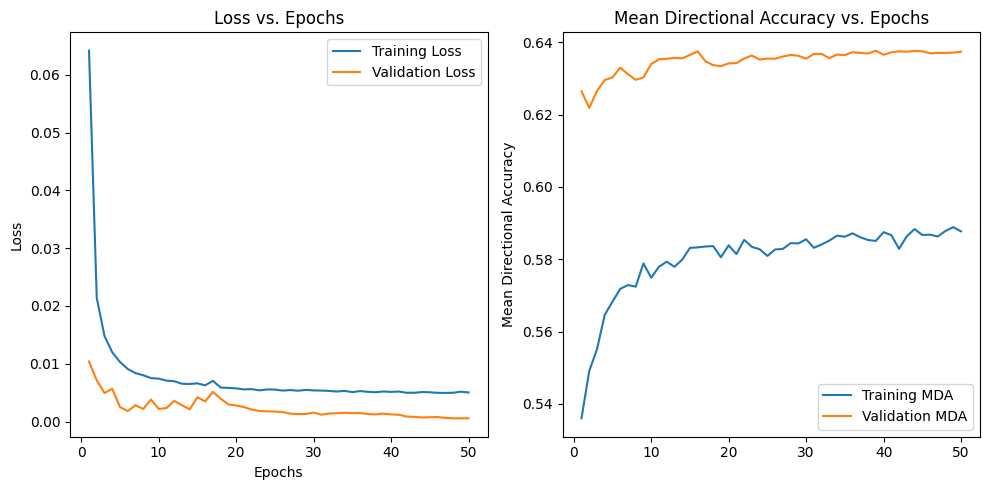

814/814 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step


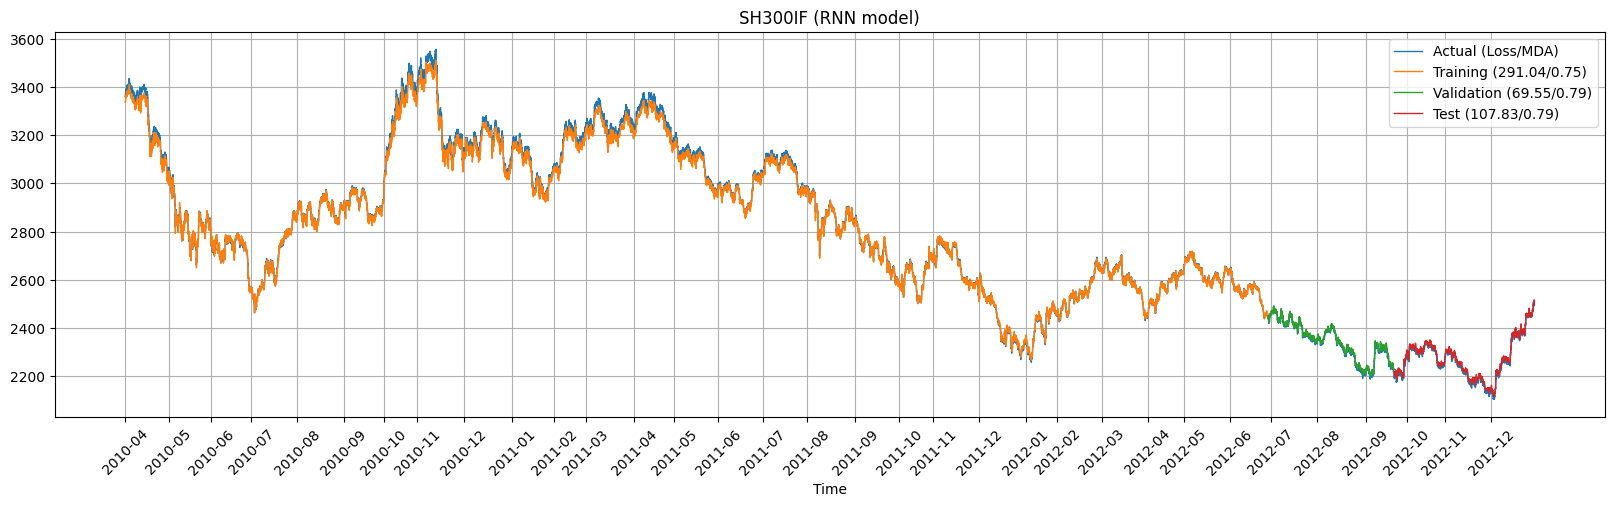

Loading dataset... Ready for training.
Epoch 1/50

Epoch 1: val_loss improved from inf to 0.00953, saving model to C:\Users\HW\Desktop\Deep Learning\01Assignment\a3\scr\models\GRU_bestweights.keras
814/814 - 6s - 8ms/step - loss: 0.0753 - mda: 0.5420 - rmse: 0.1951 - val_loss: 0.0095 - val_mda: 0.6452 - val_rmse: 0.0918 - learning_rate: 1.0000e-04
Epoch 2/50

Epoch 2: val_loss improved from 0.00953 to 0.00062, saving model to C:\Users\HW\Desktop\Deep Learning\01Assignment\a3\scr\models\GRU_bestweights.keras
814/814 - 4s - 4ms/step - loss: 0.0154 - mda: 0.5621 - rmse: 0.1168 - val_loss: 6.2466e-04 - val_mda: 0.6452 - val_rmse: 0.0317 - learning_rate: 1.0000e-04
Epoch 3/50

Epoch 3: val_loss improved from 0.00062 to 0.00056, saving model to C:\Users\HW\Desktop\Deep Learning\01Assignment\a3\scr\models\GRU_bestweights.keras
814/814 - 4s - 4ms/step - loss: 0.0108 - mda: 0.5643 - rmse: 0.1009 - val_loss: 5.5615e-04 - val_mda: 0.6448 - val_rmse: 0.0312 - learning_rate: 1.0000e-04
Epoch 4/50



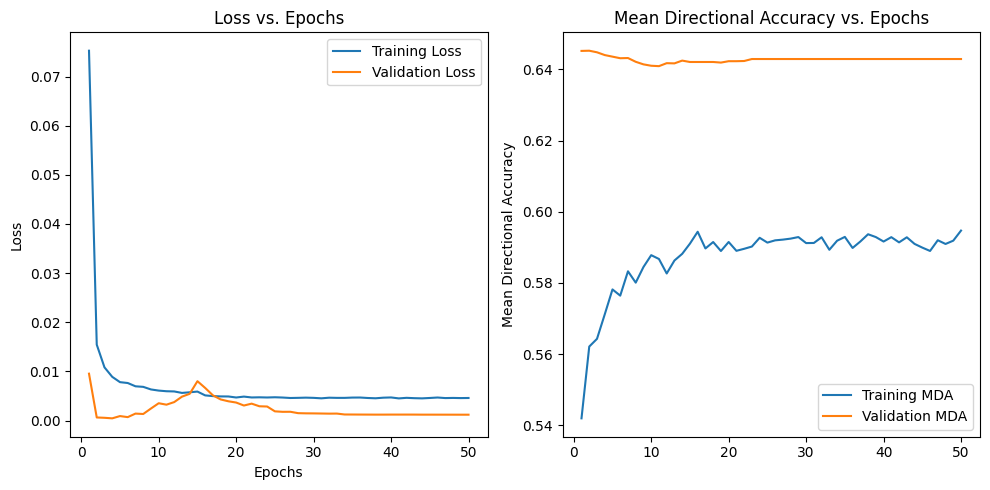

814/814 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


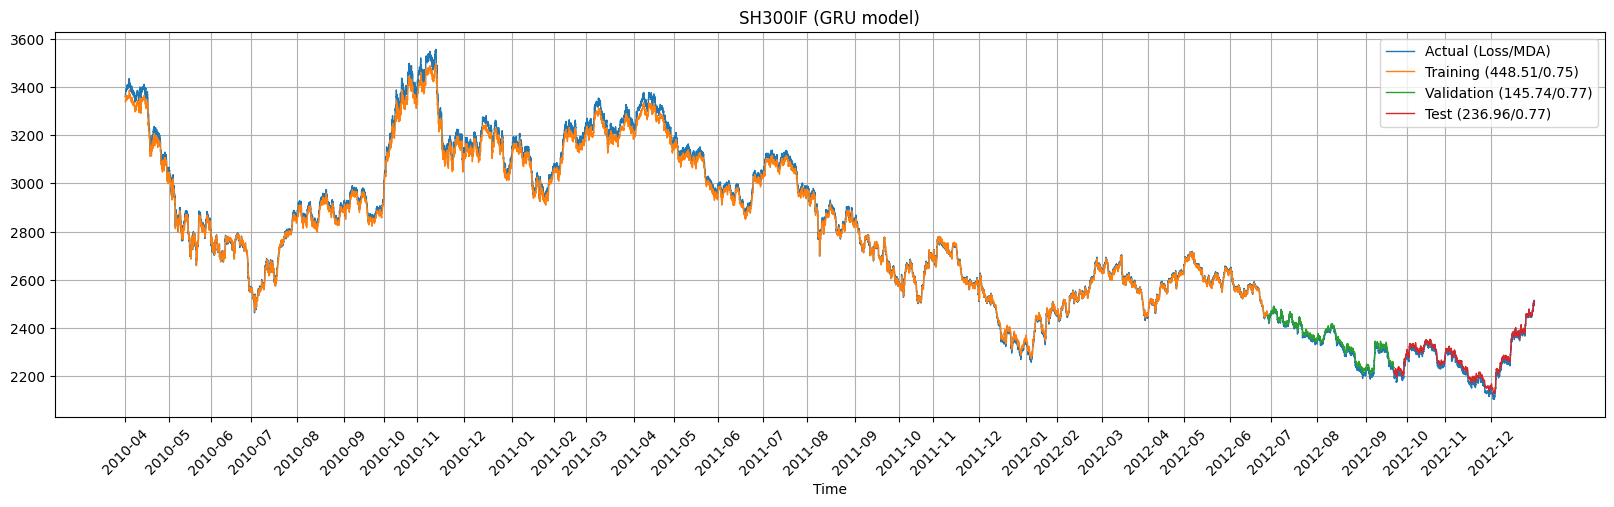

Loading dataset... Ready for training.
Stock Index Code: SH300IF
Train Set Length: 26048
Validation Set Length: 2880
Test Set Length: 3200
Epoch 1/50

Epoch 1: val_loss improved from inf to 0.01880, saving model to C:\Users\HW\Desktop\Deep Learning\01Assignment\a3\scr\models\LSTM_bestweights.keras
814/814 - 6s - 7ms/step - loss: 0.0644 - mda: 0.5412 - rmse: 0.1709 - val_loss: 0.0188 - val_mda: 0.6488 - val_rmse: 0.1241 - learning_rate: 1.0000e-04
Epoch 2/50

Epoch 2: val_loss improved from 0.01880 to 0.00597, saving model to C:\Users\HW\Desktop\Deep Learning\01Assignment\a3\scr\models\LSTM_bestweights.keras
814/814 - 3s - 4ms/step - loss: 0.0141 - mda: 0.5559 - rmse: 0.1090 - val_loss: 0.0060 - val_mda: 0.6497 - val_rmse: 0.0743 - learning_rate: 1.0000e-04
Epoch 3/50

Epoch 3: val_loss improved from 0.00597 to 0.00553, saving model to C:\Users\HW\Desktop\Deep Learning\01Assignment\a3\scr\models\LSTM_bestweights.keras
814/814 - 3s - 4ms/step - loss: 0.0115 - mda: 0.5655 - rmse: 0.1003 -

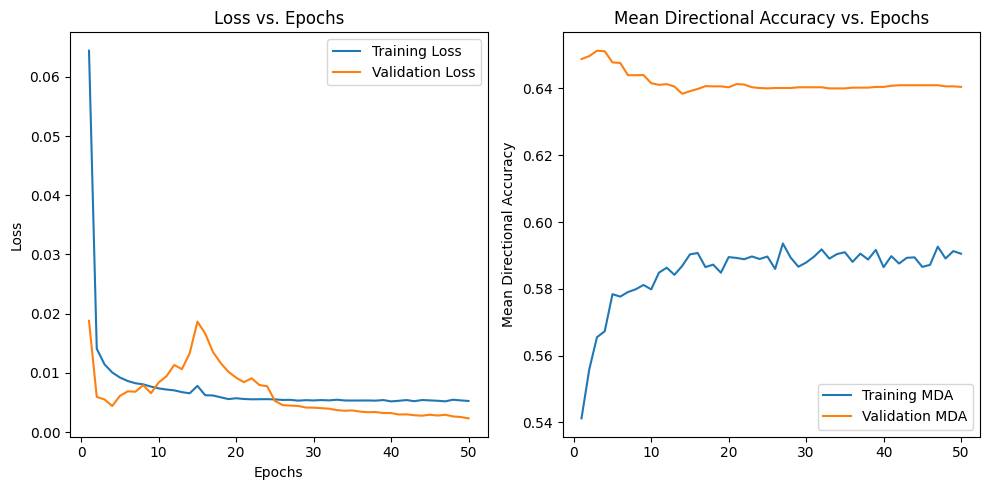

814/814 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


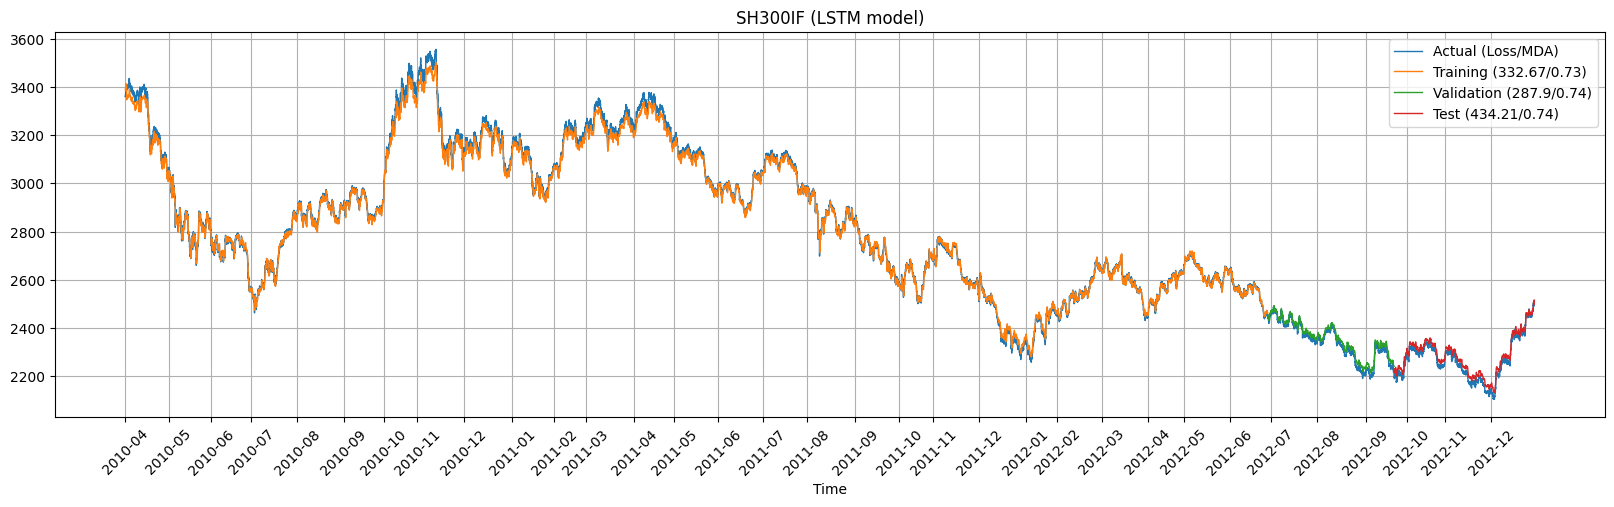

------------------------------------------------------------------------------------------------------

Window: time step = 36, forecast step = 1, window = 36
Loading dataset... Ready for training.
Stock Index Code: SH300IF
Train Set Length: 26048
Validation Set Length: 2880
Test Set Length: 3200
Epoch 1/50

Epoch 1: val_loss improved from inf to 0.01444, saving model to C:\Users\HW\Desktop\Deep Learning\01Assignment\a3\scr\models\RNN_bestweights.keras
814/814 - 7s - 8ms/step - loss: 0.0957 - mda: 0.5366 - rmse: 0.2235 - val_loss: 0.0144 - val_mda: 0.6424 - val_rmse: 0.1174 - learning_rate: 1.0000e-04
Epoch 2/50

Epoch 2: val_loss improved from 0.01444 to 0.00539, saving model to C:\Users\HW\Desktop\Deep Learning\01Assignment\a3\scr\models\RNN_bestweights.keras
814/814 - 4s - 5ms/step - loss: 0.0235 - mda: 0.5527 - rmse: 0.1400 - val_loss: 0.0054 - val_mda: 0.6450 - val_rmse: 0.0733 - learning_rate: 1.0000e-04
Epoch 3/50

Epoch 3: val_loss improved from 0.00539 to 0.00055, saving model

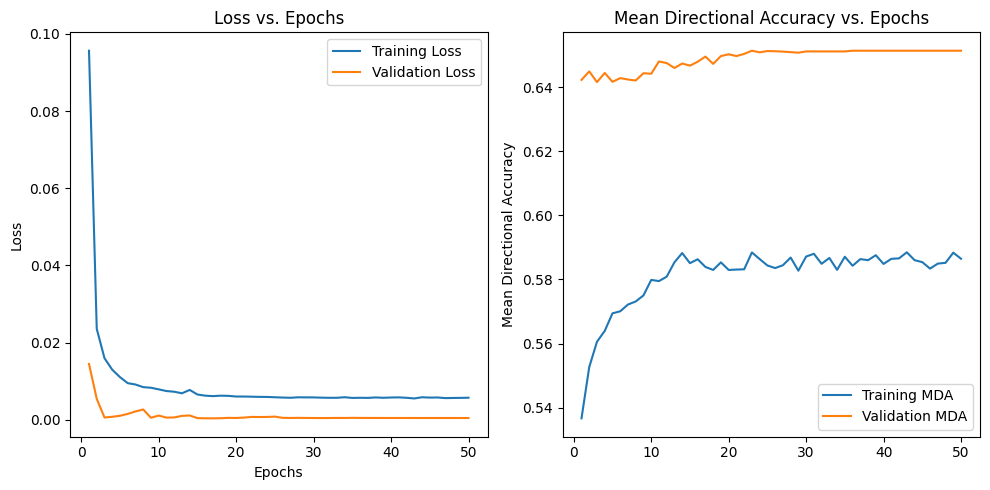

814/814 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


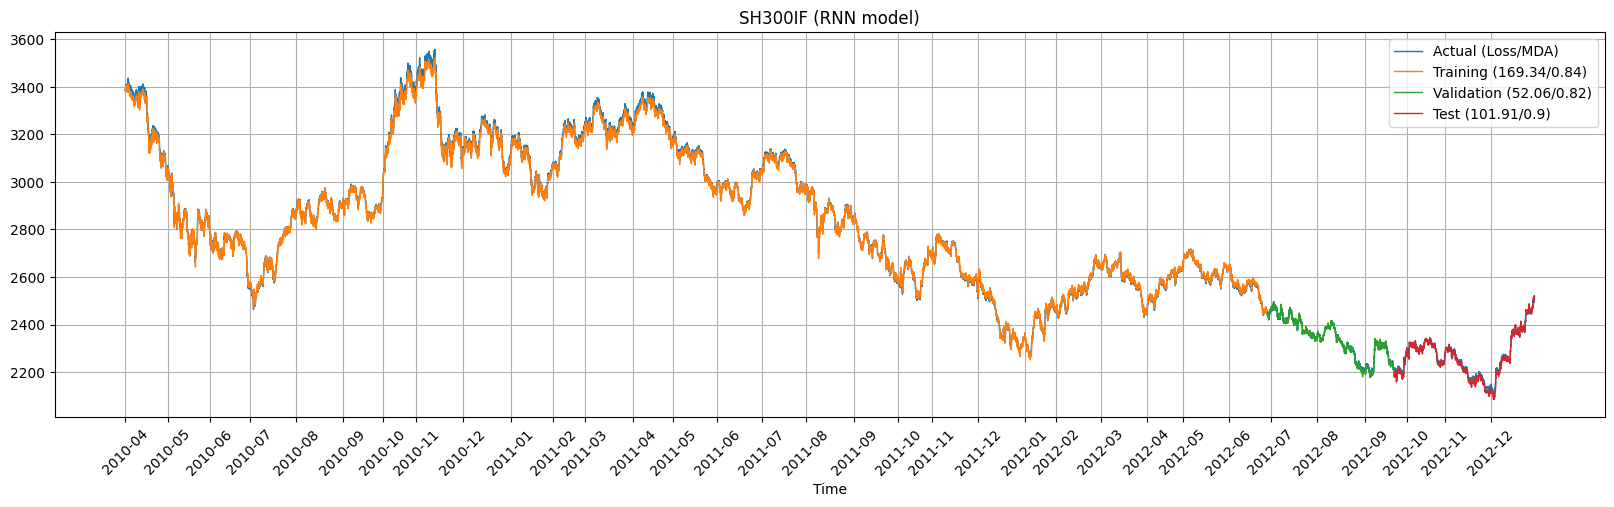

Loading dataset... Ready for training.
Epoch 1/50

Epoch 1: val_loss improved from inf to 0.02119, saving model to C:\Users\HW\Desktop\Deep Learning\01Assignment\a3\scr\models\GRU_bestweights.keras
814/814 - 18s - 22ms/step - loss: 0.1344 - mda: 0.5387 - rmse: 0.2356 - val_loss: 0.0212 - val_mda: 0.6515 - val_rmse: 0.1372 - learning_rate: 1.0000e-04
Epoch 2/50

Epoch 2: val_loss improved from 0.02119 to 0.01082, saving model to C:\Users\HW\Desktop\Deep Learning\01Assignment\a3\scr\models\GRU_bestweights.keras
814/814 - 12s - 15ms/step - loss: 0.0162 - mda: 0.5629 - rmse: 0.1176 - val_loss: 0.0108 - val_mda: 0.6529 - val_rmse: 0.0995 - learning_rate: 1.0000e-04
Epoch 3/50

Epoch 3: val_loss improved from 0.01082 to 0.00522, saving model to C:\Users\HW\Desktop\Deep Learning\01Assignment\a3\scr\models\GRU_bestweights.keras
814/814 - 12s - 15ms/step - loss: 0.0120 - mda: 0.5660 - rmse: 0.1043 - val_loss: 0.0052 - val_mda: 0.6534 - val_rmse: 0.0707 - learning_rate: 1.0000e-04
Epoch 4/50

Ep

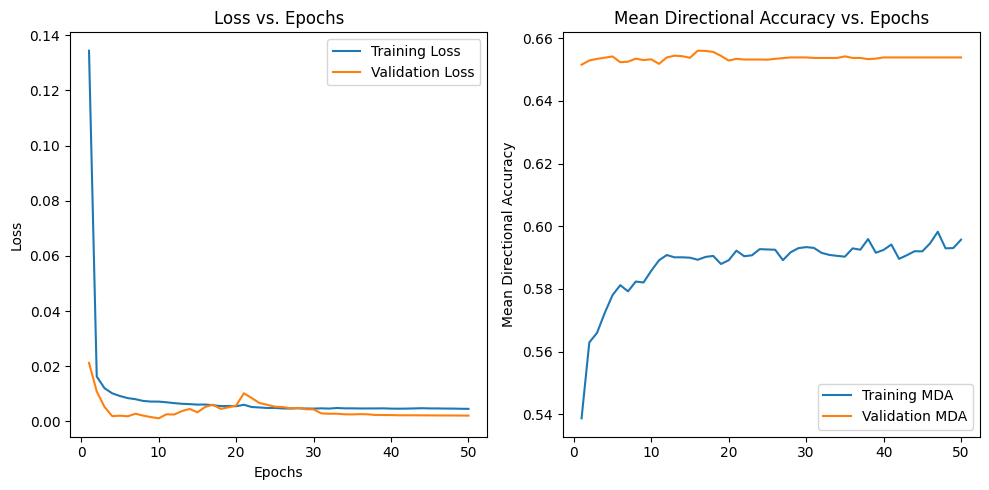

814/814 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


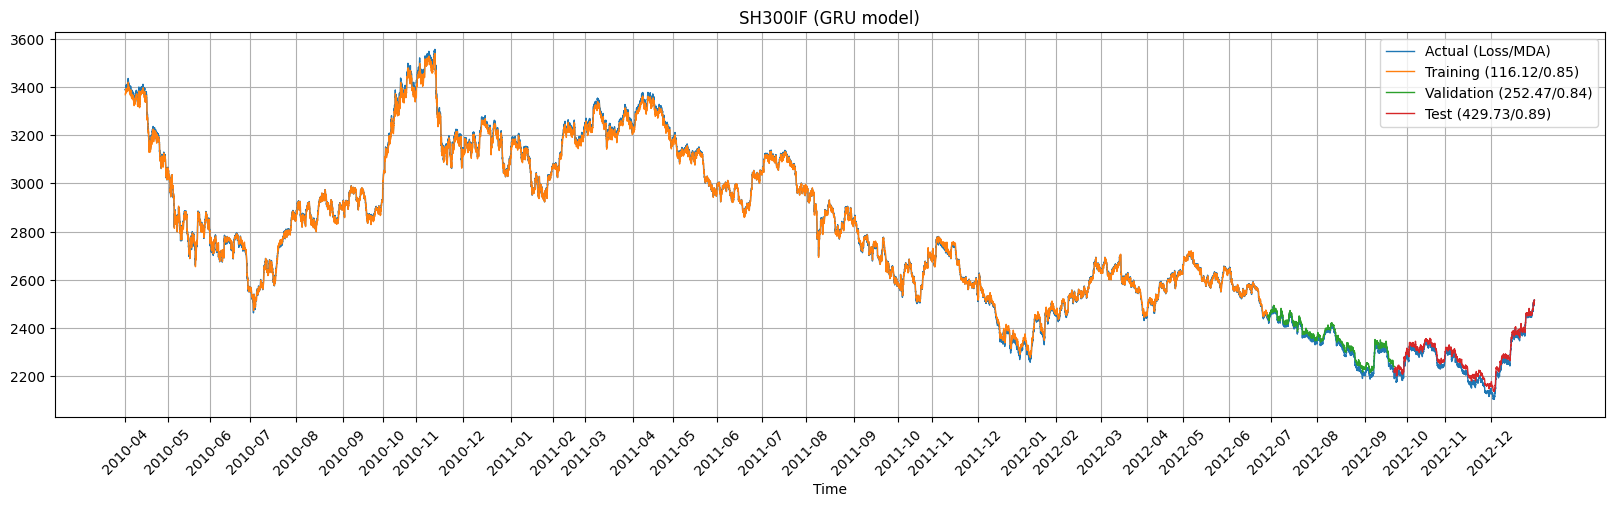

Loading dataset... Ready for training.
Stock Index Code: SH300IF
Train Set Length: 26048
Validation Set Length: 2880
Test Set Length: 3200
Epoch 1/50

Epoch 1: val_loss improved from inf to 0.01249, saving model to C:\Users\HW\Desktop\Deep Learning\01Assignment\a3\scr\models\LSTM_bestweights.keras
814/814 - 16s - 19ms/step - loss: 0.0808 - mda: 0.5454 - rmse: 0.1786 - val_loss: 0.0125 - val_mda: 0.6561 - val_rmse: 0.1003 - learning_rate: 1.0000e-04
Epoch 2/50

Epoch 2: val_loss improved from 0.01249 to 0.01219, saving model to C:\Users\HW\Desktop\Deep Learning\01Assignment\a3\scr\models\LSTM_bestweights.keras
814/814 - 12s - 14ms/step - loss: 0.0155 - mda: 0.5597 - rmse: 0.1118 - val_loss: 0.0122 - val_mda: 0.6561 - val_rmse: 0.1024 - learning_rate: 1.0000e-04
Epoch 3/50

Epoch 3: val_loss improved from 0.01219 to 0.01071, saving model to C:\Users\HW\Desktop\Deep Learning\01Assignment\a3\scr\models\LSTM_bestweights.keras
814/814 - 12s - 14ms/step - loss: 0.0123 - mda: 0.5677 - rmse: 0.

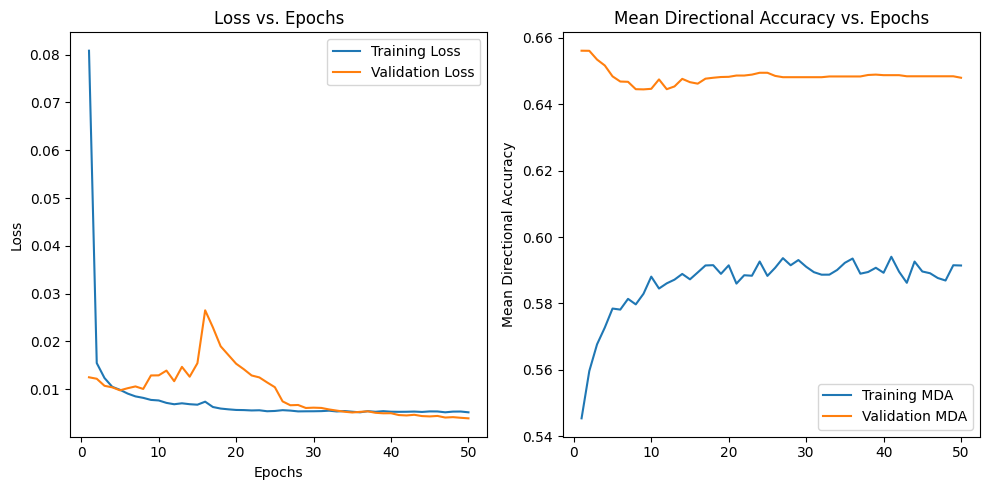

814/814 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step
90/90 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


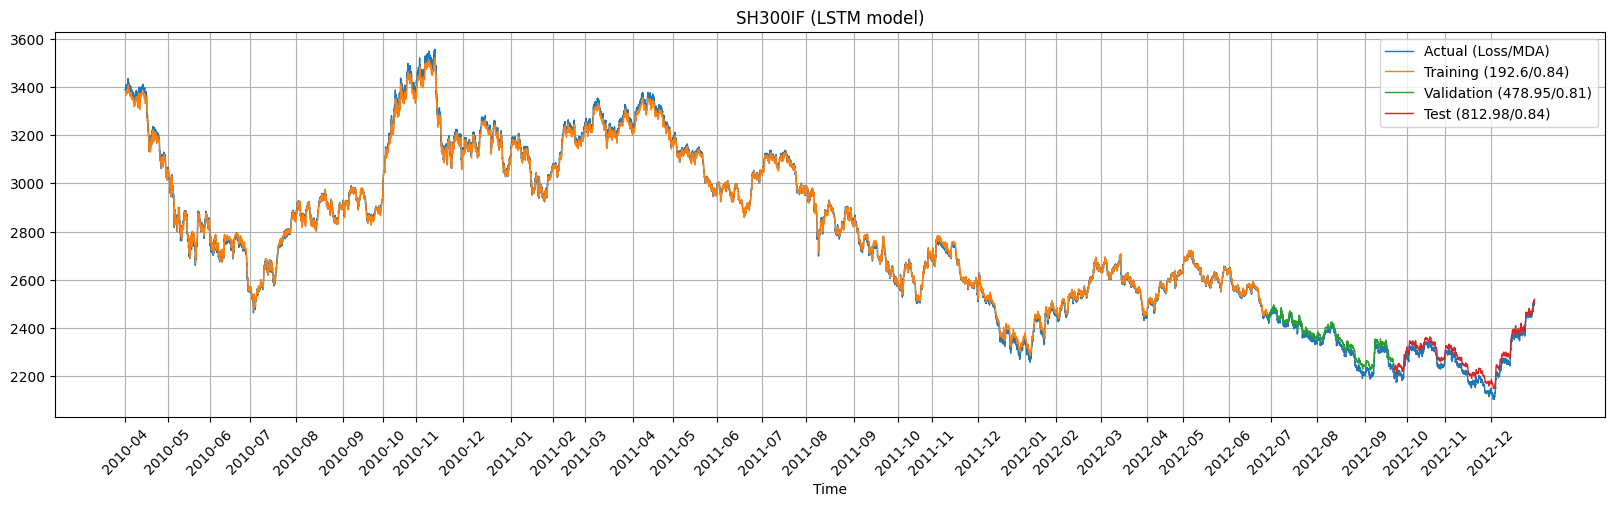

------------------------------------------------------------------------------------------------------

Window: time step = 288, forecast step = 1, window = 288
Loading dataset... Ready for training.
Stock Index Code: SH300IF
Train Set Length: 25824
Validation Set Length: 2848
Test Set Length: 3168
Epoch 1/50

Epoch 1: val_loss improved from inf to 0.01835, saving model to C:\Users\HW\Desktop\Deep Learning\01Assignment\a3\scr\models\RNN_bestweights.keras
807/807 - 33s - 41ms/step - loss: 0.1450 - mda: 0.5251 - rmse: 0.2559 - val_loss: 0.0184 - val_mda: 0.6671 - val_rmse: 0.1326 - learning_rate: 1.0000e-04
Epoch 2/50

Epoch 2: val_loss improved from 0.01835 to 0.00758, saving model to C:\Users\HW\Desktop\Deep Learning\01Assignment\a3\scr\models\RNN_bestweights.keras
807/807 - 21s - 26ms/step - loss: 0.0289 - mda: 0.5494 - rmse: 0.1519 - val_loss: 0.0076 - val_mda: 0.6726 - val_rmse: 0.0905 - learning_rate: 1.0000e-04
Epoch 3/50

Epoch 3: val_loss improved from 0.00758 to 0.00601, saving

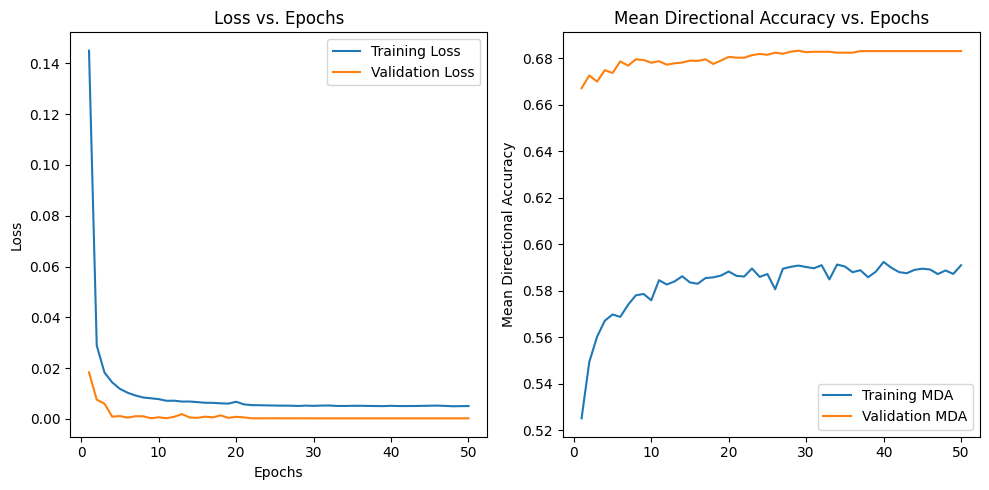

807/807 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


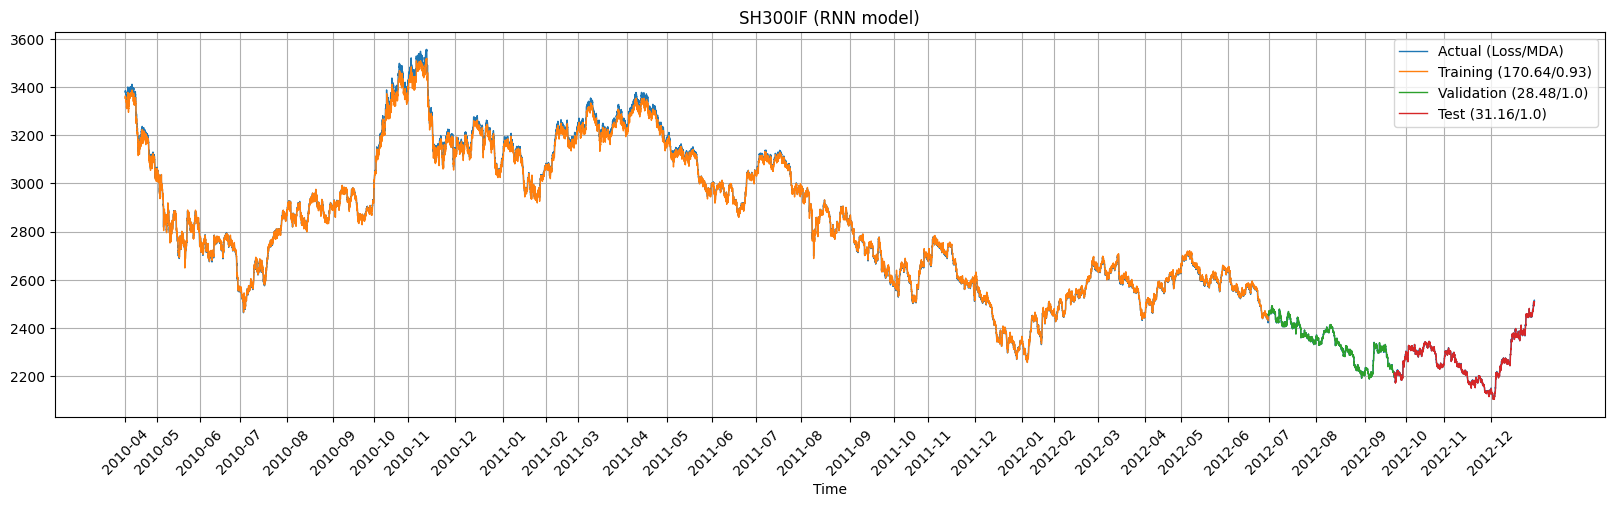

Loading dataset... Ready for training.
Epoch 1/50

Epoch 1: val_loss improved from inf to 0.02215, saving model to C:\Users\HW\Desktop\Deep Learning\01Assignment\a3\scr\models\GRU_bestweights.keras
807/807 - 117s - 144ms/step - loss: 0.0875 - mda: 0.5433 - rmse: 0.2009 - val_loss: 0.0221 - val_mda: 0.6908 - val_rmse: 0.1423 - learning_rate: 1.0000e-04
Epoch 2/50

Epoch 2: val_loss improved from 0.02215 to 0.01023, saving model to C:\Users\HW\Desktop\Deep Learning\01Assignment\a3\scr\models\GRU_bestweights.keras
807/807 - 92s - 114ms/step - loss: 0.0151 - mda: 0.5602 - rmse: 0.1145 - val_loss: 0.0102 - val_mda: 0.6899 - val_rmse: 0.0993 - learning_rate: 1.0000e-04
Epoch 3/50

Epoch 3: val_loss improved from 0.01023 to 0.00368, saving model to C:\Users\HW\Desktop\Deep Learning\01Assignment\a3\scr\models\GRU_bestweights.keras
807/807 - 97s - 120ms/step - loss: 0.0107 - mda: 0.5693 - rmse: 0.0993 - val_loss: 0.0037 - val_mda: 0.6907 - val_rmse: 0.0625 - learning_rate: 1.0000e-04
Epoch 4/50

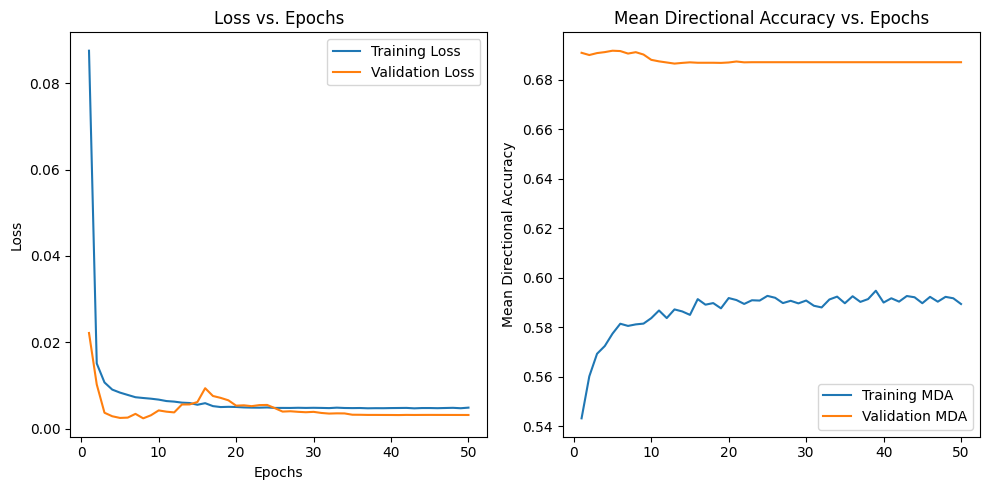

807/807 ━━━━━━━━━━━━━━━━━━━━ 52s 53ms/step
89/89 ━━━━━━━━━━━━━━━━━━━━ 5s 54ms/step
99/99 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step


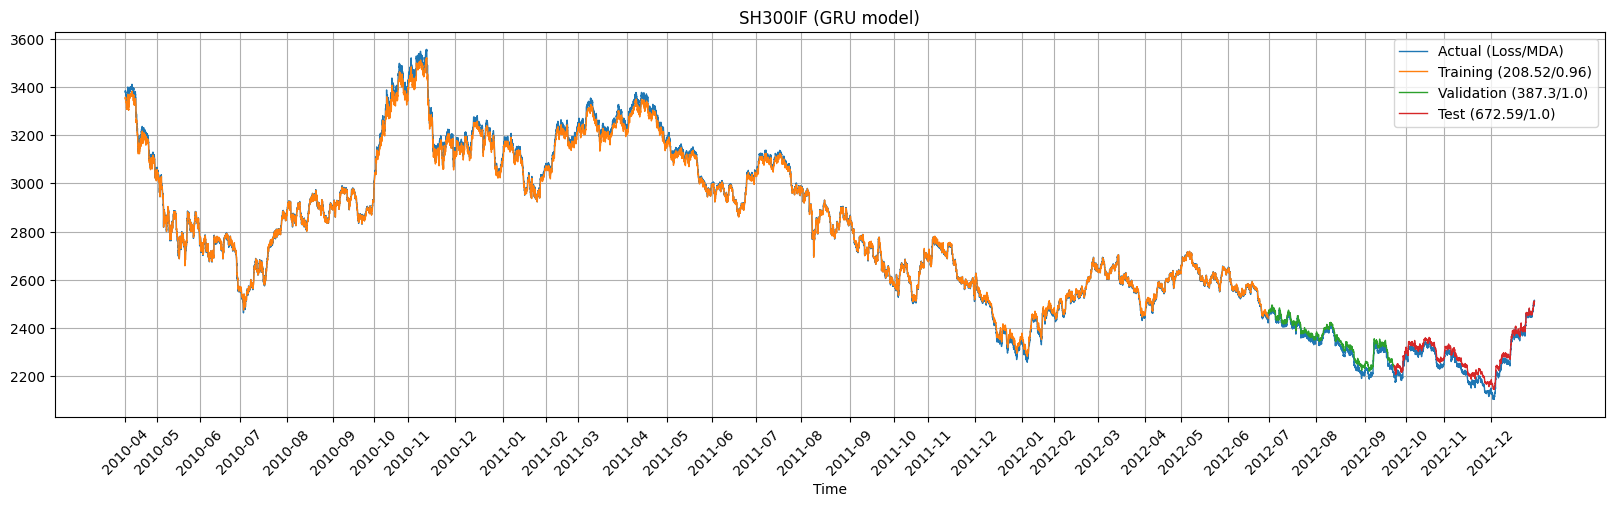

Loading dataset... Ready for training.
Stock Index Code: SH300IF
Train Set Length: 25824
Validation Set Length: 2848
Test Set Length: 3168
Epoch 1/50


SystemError: \Objects\listobject.c:338: bad argument to internal function

In [ ]:
# Optimized window steps
# The ratio of time_steps and forecast_steps
windows = [
    (12,6,12), (12, 1, 12), (36, 1, 36)
]
RNN_pred_lst = []
GRU_pred_lst = []
LSTM_pred_lst = []

for window in windows:
    print(f"Window: time step = {window[0]}, forecast step = {window[1]}, window = {window[2]}")
    RNN_params['time_steps'] = window[0]
    RNN_params['forecast_steps'] = window[1]
    RNN_params['window'] = window[2]
    RNN_pred_lst.append(trainRNN(datasets_path[0], RNN_params))

    GRU_params['time_steps'] = window[0]
    GRU_params['forecast_steps'] = window[1]
    GRU_params['window'] = window[2]
    GRU_pred_lst.append(trainGRU(datasets_path[0], GRU_params))

    LSTM_params['time_steps'] = window[0]
    LSTM_params['forecast_steps'] = window[1]
    LSTM_params['window'] = window[2]
    LSTM_pred_lst.append(trainLSTM(datasets_path[0], LSTM_params))
    print("------------------------------------------------------------------------------------------------------")
    print()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ['RNN', 'LSTM', 'GRU']
combos = ['12,6', '3,1', '36,1']
mse_data = [
    [116.99, 191.87, 75.73],  # RNN
    [648.77, 372.04, 206.26], # LSTM
    [359.36, 366.05, 235.45]  # GRU
]
mda_data = [
    [0.64, 0.53, 0.82],  # RNN
    [0.6, 0.5, 0.82],    # LSTM
    [0.63, 0.49, 0.82]   # GRU
]

# Define positions
x = np.arange(len(combos))  # Combo positions
width = 0.25                # Bar width

# Initialize the figure and axes
fig, axs = plt.subplots(2, 1, figsize=(8, 10), sharex=True)

# Function to annotate bars
def annotate_bars(ax, bars, values):
    for bar, value in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height + 0.02, f'{value:.2f}',
                ha='center', va='bottom', fontsize=10)

# Plot MSE (Top)
for i, model in enumerate(models):
    bars = axs[0].bar(x + i * width, mse_data[i], width, label=model)
    annotate_bars(axs[0], bars, mse_data[i])
axs[0].set_title('MSE by Model and Combo')
axs[0].set_ylabel('MSE')
axs[0].legend()
axs[0].grid(axis='y', linestyle='--', alpha=0.7)

# Plot MDA (Bottom)
for i, model in enumerate(models):
    bars = axs[1].bar(x + i * width, mda_data[i], width, label=model)
    annotate_bars(axs[1], bars, mda_data[i])
axs[1].set_title('MDA by Model and Combo')
axs[1].set_ylabel('MDA')
axs[1].set_xlabel('Combo')
axs[1].legend()
axs[1].grid(axis='y', linestyle='--', alpha=0.7)

# Set x-ticks and labels
axs[1].set_xticks(x + width)
axs[1].set_xticklabels(combos)

# Adjust layout
plt.tight_layout()
plt.show()


In [ ]:
# Plot and compare the results obtained from the three RNNs on the test data set
RNNdata = StockIndexDataset(datasets_path[0], time_steps=RNN_params['time_steps'],
                            forecast_steps=RNN_params['forecast_steps'],
                            batch_size=RNN_params['batch_size'], val_ratio=.1, test_ratio=.1)

RNN_predictions = RNN_pred_lst[2]
GRU_predictions = GRU_pred_lst[2]
LSTM_predictions = LSTM_pred_lst[2]

testset = [RNN_predictions.true_org[2], 
           RNN_predictions.predictions_org[2],
           GRU_predictions.predictions_org[2],
           LSTM_predictions.predictions_org[2]]
datetime = pd.Series(RNNdata.datetime[2].values, 
                     index = RNN_predictions.true_org[2].index)
labels = ['Actual', 'RNN', 'GRU', 'LSTM']
list_mse = [RNN_predictions.loss[2],
       GRU_predictions.loss[2],
       LSTM_predictions.loss[2]]
list_mda = [RNN_predictions.mda[2],
       GRU_predictions.mda[2],
       LSTM_predictions.mda[2]]
labels_loss = create_labels(labels, list_mse, list_mda)
plot_seqs(testset, datetime=datetime, labels=labels_loss)